## Variational autoencoders on pokemons

- DATA: https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types
- PYTORCH TUTORIAL: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

- https://www.gabormelli.com/RKB/Convolutional_(CNN/CNN)-based_Encoder-Decoder_Neural_Network
- https://github.com/AntixK/PyTorch-VAE/blob/master/models/beta_vae.py

In [180]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from PIL import Image
import os

In [3]:
path = "./data/images/"
tentopil = transforms.ToPILImage()
piltoten = transforms.PILToTensor()
def imageAlphaToWhite(image):
    background = Image.new("RGBA", image.size, "WHITE")
    alphaComposite = Image.alpha_composite(background, image)
    return alphaComposite.convert("RGB")

In [617]:
class PokemonDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.image_paths = os.listdir(data_path)
        self.totensor = transforms.ToTensor()
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        img = Image.open(self.data_path+image_path).convert("RGBA")
        img = imageAlphaToWhite(img)
        img = self.totensor(img)
        return img, img

class PokemonTraining(PokemonDataset):
    def __init__(self, data_path, transforms):
        PokemonDataset.__init__(self, data_path)
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img, lbl = PokemonDataset.__getitem__(self, idx)
        return self.transforms(img), lbl

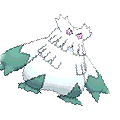

In [618]:
data = PokemonDataset(path)
transform = transforms.Compose([
    transforms.RandomRotation(20, interpolation=transforms.InterpolationMode.NEAREST, fill=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale()
])
train_data = PokemonTraining(path, transform)

display(tentopil(train_data[0][0]))

In [805]:
batch_size = 1024
x_dim = tuple(data[0][0].shape)
device = 'cuda'
data[0][0].dtype

torch.float32

In [806]:
dl = DataLoader(data, batch_size=batch_size, shuffle=True)
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [781]:
class VAutoencoder(nn.Module):
    def __init__(self, input_channels=3, latent_dim=10):
        super(VAutoencoder, self).__init__()
        hidden_dims = [16, 32, 64, 128, 256, 512]
        input_channels = 3
        input_dim = input_channels
        
        self.encoder = nn.Sequential()
        for output_dim in hidden_dims:
            self.encoder.append(
                nn.Sequential(
                    nn.Conv2d(input_dim, output_dim, (3, 3), stride=2, padding=1),
                    nn.BatchNorm2d(output_dim),
                    nn.LeakyReLU(),
                ))
            input_dim = output_dim
        self.encoder.append(nn.Flatten())

        self.mean_layer = nn.Sequential(
            nn.Linear(input_dim * 4, latent_dim),
            nn.ReLU(),
        )
        self.var_layer = nn.Sequential(
            nn.Linear(input_dim * 4, latent_dim),
            nn.ReLU(),
        )
        self.from_latent = nn.Sequential(
            nn.Linear(latent_dim, input_dim * 4),
            nn.ReLU(),
        )
        self.decoder_input_dim = input_dim
        
        hidden_dims.reverse()
        output_dim = input_dim
        self.decoder = nn.Sequential()
        for output_dim in hidden_dims[1:]:
            self.decoder.append(
                nn.Sequential(
                    nn.ConvTranspose2d(input_dim, output_dim, (3, 3), stride=2, padding=1),
                    nn.LeakyReLU(),
                ))
            input_dim = output_dim
        self.decoder.append(
            nn.Sequential(
                nn.UpsamplingBilinear2d(60),
                nn.ConvTranspose2d(input_dim, input_channels, (3, 3), stride=2, padding=1),
                nn.Upsample(118),
                nn.ConvTranspose2d(input_channels, input_channels, (3, 3), stride=1, padding=0),
                nn.Sigmoid(),
            ))
        
    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        logvar = self.var_layer(x)
        return mean, logvar
        
    def reparametrization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std).to(device)
        z = mean + std*epsilon
        return z
    
    def decode(self, x):
        x = self.from_latent(x)
        x = x.view(-1, self.decoder_input_dim, 2, 2)
        x_hat = self.decoder(x)
        return x_hat
        
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparametrization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
    
#     def train(self, mode=True):
#         for m in self.modules():
#             if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
#                 m.eval()
#                 m.weight.requires_grad = False
#                 m.bias.requires_grad = False

In [822]:
def loss_function(x, x_hat, mean, logvar):
    mse = nn.functional.mse_loss(x_hat, x, reduction='sum')
    log_sigma_opt = 0.5 * mse.log()
    r_loss = 0.5 * torch.pow((x - x_hat) / log_sigma_opt.exp(), 2) + log_sigma_opt
    r_loss = r_loss.sum()
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return r_loss + kl_loss
    
#     mse_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    #     reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
#     KLD = - 0.5 * torch.sum(1+ logvar - mean.pow(2) - logvar.exp())
#     return mse_loss

In [803]:
model = VAutoencoder().to(device)
model.load_state_dict(torch.load("./models/1000epochs-no-kld"))

<All keys matched successfully>

In [823]:
def train(model, optimizer, epochs, prints=1, disp=False):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        size = 0
        for batch_idx, (x, y) in enumerate(train_dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            x_hat, mean, logvar = model(x)
            loss = loss_function(y, x_hat, mean, logvar)
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()
            if disp and batch_idx==0:
                for i in range(10):
                    display(tentopil(x[i]))
                    display(tentopil(x_hat[i]))
            size += len(x)

        if (epoch) % prints == 0:
            print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(size))
    return overall_loss

In [856]:
# torch.save(model.state_dict(), "./models/1000epochs-no-kld-2")

In [814]:
# model = torch.load("./models/1000epochs-no-kld")
# modelload_state_dict

In [831]:
train(model, Adam(model.parameters(), lr=1e-3), epochs=1000, prints=25)

	Epoch 1 	Average Loss:  282679.41656365886
	Epoch 26 	Average Loss:  268279.5352286774
	Epoch 51 	Average Loss:  268001.4437577256
	Epoch 76 	Average Loss:  267787.68850432633
	Epoch 101 	Average Loss:  267720.3461063041
	Epoch 126 	Average Loss:  267615.74289245985
	Epoch 151 	Average Loss:  267571.0259579728
	Epoch 176 	Average Loss:  267425.89864029665
	Epoch 201 	Average Loss:  267332.88504326326
	Epoch 226 	Average Loss:  267350.2892459827
	Epoch 251 	Average Loss:  267279.54511742893
	Epoch 276 	Average Loss:  267183.9208899876
	Epoch 301 	Average Loss:  267104.9888751545
	Epoch 326 	Average Loss:  266988.04449938197
	Epoch 351 	Average Loss:  267031.93077873916
	Epoch 376 	Average Loss:  266912.7119901113
	Epoch 401 	Average Loss:  266915.1644004944
	Epoch 426 	Average Loss:  266826.7589616811
	Epoch 451 	Average Loss:  266680.06922126084
	Epoch 476 	Average Loss:  266698.38318912237
	Epoch 501 	Average Loss:  266449.4635352287
	Epoch 526 	Average Loss:  266569.7107540173
	Epoc

214748560.0

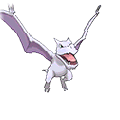

In [885]:
display(tentopil(train_data[5][0]))

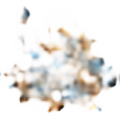

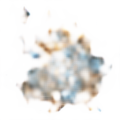

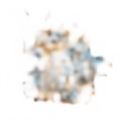

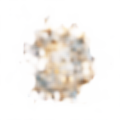

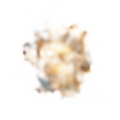

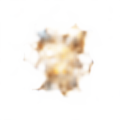

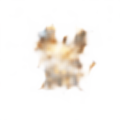

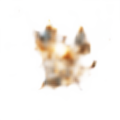

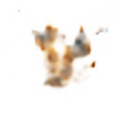

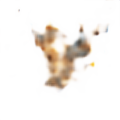

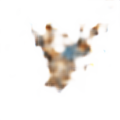

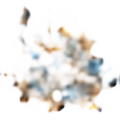

In [893]:
sample = train_data[0][0][None, :].to(device)
sample_2 = train_data[5][0][None, :].to(device)
with torch.no_grad():
    latent = model.encode(sample)[0]
    start = latent
    end = model.encode(sample_2)[0]
#     start = torch.zeros_like(latent)
#     end = torch.ones_like(latent)
#     start[0][0] = -1
#     start[0][1] = -19
    for i in torch.arange(0, 1.1, 0.1).to(device):
        x = torch.lerp(start, end, i).to(device)
        display(tentopil(model.decode(x)[0]))
    display(tentopil(model.forward(sample)[0][0]))

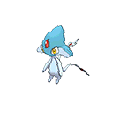

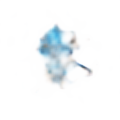

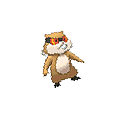

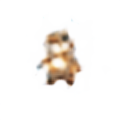

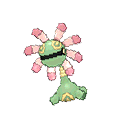

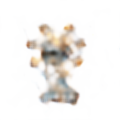

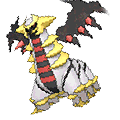

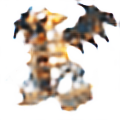

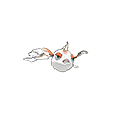

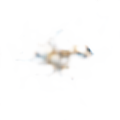

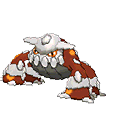

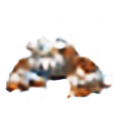

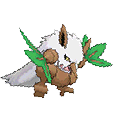

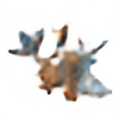

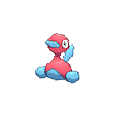

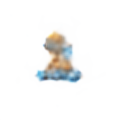

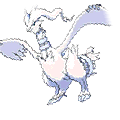

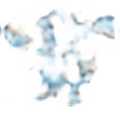

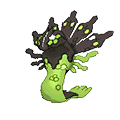

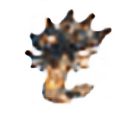

	Epoch 1 	Average Loss:  265509.0630407911


214796832.0

In [832]:
train(model, Adam(model.parameters(), lr=1e-3), epochs=1, prints=1, disp=True)

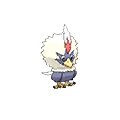

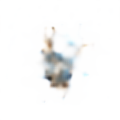

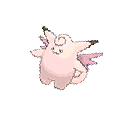

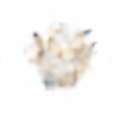

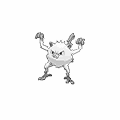

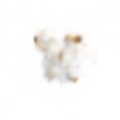

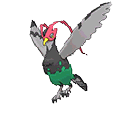

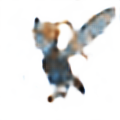

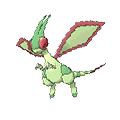

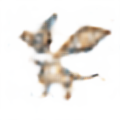

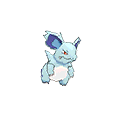

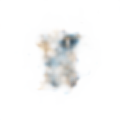

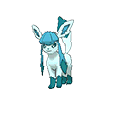

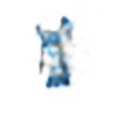

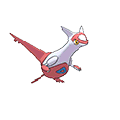

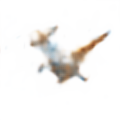

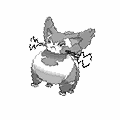

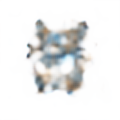

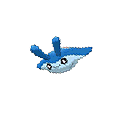

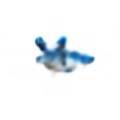

	Epoch 1 	Average Loss:  268155.62917181704


216937904.0

In [827]:
train(model, Adam(model.parameters(), lr=1e-3), epochs=1, prints=1, disp=True)

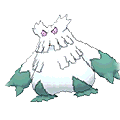

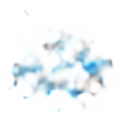

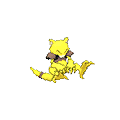

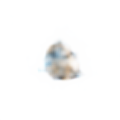

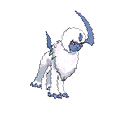

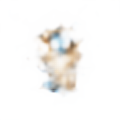

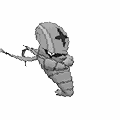

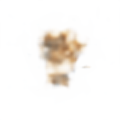

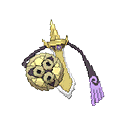

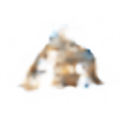

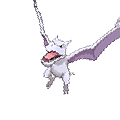

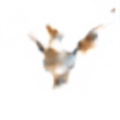

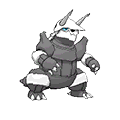

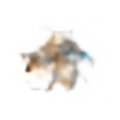

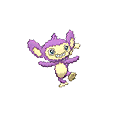

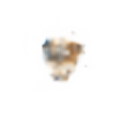

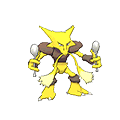

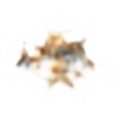

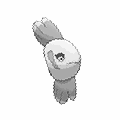

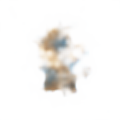

In [830]:
for i in range(10):
    img = train_data[i][0].to(device)
    with torch.no_grad():
#         mean, var = model.encode(img.unsqueeze(dim=0))
#         print(mean.shape)
#         z = model.reparametrization(mean, var)
#         x_hat = model.decode(mean).squeeze(dim=0)
#         print(x_hat.shape)
        x_hat = model.forward(img.unsqueeze(dim=0))[0].squeeze(dim=0)
        display(tentopil(img), tentopil(x_hat))

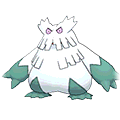

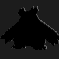

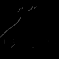

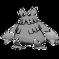

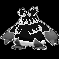

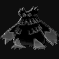

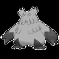

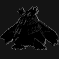

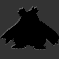

In [1141]:
img = data[i][0].to(device).unsqueeze(dim=0)
out = model.encoder[0:3](img).squeeze(dim=0)

display(tentopil(img.squeeze()))
for i in range(8):
    display(tentopil(out[i]))
# out.shape

In [ ]:
img = data[10][0]
print(img.shape)
tentopil = transforms.ToPILImage()
piltoten = transforms.PILToTensor()
# tentopil(img[0:2])
# img.max()


In [905]:
data[i][0].unsqueeze(0)[:, 1].shape

torch.Size([1, 120, 120])